Step 0. Run the notebook containing all class definitions. It will generate some plots. Wait until it is done and go to Cell->Current Output-> Clear to make things tidy.

In [1]:
%run "Tapering Protocol Comparison Utils".ipynb

### 1. Creating different impulse responses 

First let us look at a very simple linear models that aims to capture the effects of an abstract stimulant over time. The A process would correspond to released (& bonded) dopamine, while the B process would correspond to slow increases in the dopamine receptors (leading to increased reuptake). A timestep is one day. We have two systems below, one for hard drugs, and one for more medication type drugs. For now we will only work with the first system and hence only plot its impulse response. Other systems will be added here.

In [36]:
med_lin_sys = system(create_linear_impulse(np.array([[0.001, 0], [0, 0.9]], dtype=object),
                                    np.array([6, 0.5]), np.array([1, -1]), 180))
hrd_lin_sys = system(create_linear_impulse(np.array([[0.001, 0], [0, 0.75]], dtype=object),
                                np.array([6, 2]), np.array([1, -1]), 180))

In order to study the different protocols, we first need to start off in an 'addicted' state of the system. We vizualize this below, where we assume addiction happened due to taking 1 unit of dose every day for 60 days:

In [37]:
addict_T = 60
addict_dose = 1
addict_dose_history = list(addict_dose * np.ones(addict_T))

### 2. Testing out different protocols on a population

First let's consider the situation where all units have the same underlying dose response (Drug A), and experience some uniform noise on each measurement and each unit has a desired obs_min drawn uniformly from (-1,1).

In [38]:
drug = 'A'

In [39]:
trials = 100
noise_lb, noise_ub = (-0.25, 0.25)
taper_T = 30

In [40]:
if drug == 'A':
    obs_min_lb, obs_min_ub = -1, 1
    test_system = med_lin_sys
elif drug == 'B':
    obs_min_lb, obs_min_ub = -4.25, -2.25
    test_system = hrd_lin_sys

In [41]:
viol_mean = {}
viol_std = {}
subopt_mean = {}
subopt_std = {}

In [42]:
# 1. Cold Turkey
viol_mean['ct'], viol_std['ct'], \
subopt_mean['ct'], subopt_std['ct'] = test_population(trials, system=test_system, \
                                                    noise_generator=uniform(noise_lb, noise_ub), \
                                                    obs_min_generator=uniform(obs_min_lb, obs_min_ub),
                                                    protocol=cold_turkey, taper_T=taper_T)

In [43]:
# 2. Linear
lin_rates = {}

lin_rates['A'] = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1]
lin_rates['B'] = [0.05, 0.1, 0.15, 0.2, 0.25]

for lin_rate in lin_rates[drug]:
    viol_mean['lin-'+str(lin_rate)], viol_std['lin-'+str(lin_rate)], \
    subopt_mean['lin-'+str(lin_rate)], subopt_std['lin-'+str(lin_rate)] = test_population(trials, system=test_system, \
                                                    noise_generator=uniform(noise_lb, noise_ub), \
                                                    obs_min_generator=uniform(obs_min_lb, obs_min_ub),
                                                    protocol=linear(addict_dose, lin_rate), taper_T=taper_T)

In [44]:
# 3. Exponential
exp_rates = {}
exp_rates['A'] = [0.8, 0.9, 0.95, 0.97, 0.98, 0.99]
exp_rates['B'] = [0.5, 0.6, 0.7, 0.9, 0.95]

for exp_rate in exp_rates[drug]:
    viol_mean['exp-'+str(exp_rate)], viol_std['exp-'+str(exp_rate)], \
    subopt_mean['exp-'+str(exp_rate)], subopt_std['exp-'+str(exp_rate)] = test_population(trials, system=test_system, \
                                                    noise_generator=uniform(noise_lb, noise_ub), \
                                                    obs_min_generator=uniform(obs_min_lb, obs_min_ub),
                                                    protocol=exp(addict_dose, exp_rate), taper_T=taper_T)

In [45]:
# 4. Monotone Lookahead (default)
g0_fracs = {}
g0_fracs['A'] = [0, 0.25, 0.5, 1]
g0_fracs['B'] = [0, 0.1, 0.2, 0.5]

Ls = {}
Ls['A'] = [0.0, 0.2, 0.4, 0.6]
Ls['B'] = [0.0, 0.1, 0.2, 0.3]

for g0_frac in g0_fracs[drug]:
    g0_cons = (1+g0_frac)*test_system.g[0]
    
    for L in Ls[drug]:
        
        viol_mean['lk-'+str(g0_frac)+'-'+str(L)], viol_std['lk-'+str(g0_frac)+'-'+str(L)], \
        subopt_mean['lk-'+str(g0_frac)+'-'+str(L)], subopt_std['lk-'+str(g0_frac)+'-'+str(L)] = \
        \
                test_population(trials, system=test_system, noise_generator=uniform(noise_lb, noise_ub), \
                                obs_min_generator=uniform(obs_min_lb, obs_min_ub), \
                                protocol=lookahead(addict_dose, 0, g0_cons, L=L), taper_T=taper_T)

### 3. Plotting the Results

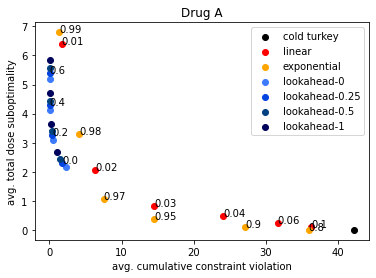

In [46]:
# 0. Initialize plot
fig, ax = plt.subplots()
plt.xlabel("avg. cumulative constraint violation")
plt.ylabel("avg. total dose suboptimality")

scale = 'linear'
plt.xscale(scale)

# 1. Plot Cold Turkey
ax.scatter(viol_mean['ct'], subopt_mean['ct'], c="black", label="cold turkey")

# 2. Plot Linear
for i, lin_rate in enumerate(lin_rates[drug]):
    if not i:
        ax.scatter(viol_mean['lin-'+str(lin_rate)], subopt_mean['lin-'+str(lin_rate)], c="red", label="linear")
        ax.annotate(str(lin_rate), (viol_mean['lin-'+str(lin_rate)], subopt_mean['lin-'+str(lin_rate)]))
    else:
        ax.scatter(viol_mean['lin-'+str(lin_rate)], subopt_mean['lin-'+str(lin_rate)], c="red")
        ax.annotate(str(lin_rate), (viol_mean['lin-'+str(lin_rate)], subopt_mean['lin-'+str(lin_rate)]))
    
# 3. Plot Exponential
for i, exp_rate in enumerate(exp_rates[drug]):
    if not i:
        ax.scatter(viol_mean['exp-'+str(exp_rate)], subopt_mean['exp-'+str(exp_rate)], c="orange", label="exponential")
        ax.annotate(str(exp_rate), (viol_mean['exp-'+str(exp_rate)], subopt_mean['exp-'+str(exp_rate)]))
    else:
        ax.scatter(viol_mean['exp-'+str(exp_rate)], subopt_mean['exp-'+str(exp_rate)], c="orange")
        ax.annotate(str(exp_rate), (viol_mean['exp-'+str(exp_rate)], subopt_mean['exp-'+str(exp_rate)]))

# 4. Plot Lookahead
g0_colors = ['lightish ', '', 'darkish ', 'dark ']
for i, g0_frac in enumerate(g0_fracs[drug]):
    for j, L in enumerate(Ls[drug]):
        if not j:
            ax.scatter(viol_mean['lk-'+str(g0_frac)+'-'+str(L)], subopt_mean['lk-'+str(g0_frac)+'-'+str(L)], \
                       c='xkcd:'+g0_colors[i]+'blue', label="lookahead-"+str(g0_frac))
            if i==1:
                ax.annotate(str(L), (viol_mean['lk-'+str(g0_frac)+'-'+str(L)], subopt_mean['lk-'+str(g0_frac)+'-'+str(L)]))
        else:
            ax.scatter(viol_mean['lk-'+str(g0_frac)+'-'+str(L)], subopt_mean['lk-'+str(g0_frac)+'-'+str(L)], \
                       c='xkcd:'+g0_colors[i]+'blue')
            if i==1:
                ax.annotate(str(L), (viol_mean['lk-'+str(g0_frac)+'-'+str(L)], subopt_mean['lk-'+str(g0_frac)+'-'+str(L)]))
                
plt.legend()
plt.title("Drug "+drug)
plt.savefig("Drug_" + drug + "_" + scale + ".pdf");

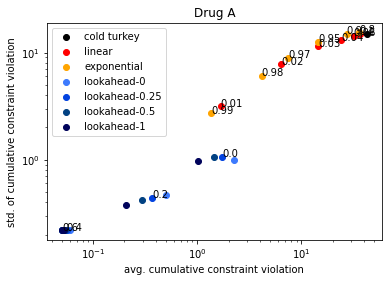

In [47]:
# 0. Initialize plot
fig, ax = plt.subplots()
plt.xlabel("avg. cumulative constraint violation")
plt.ylabel("std. of cumulative constraint violation")

scale = 'log'
plt.xscale(scale)
plt.yscale(scale)

# 1. Plot Cold Turkey
ax.scatter(viol_mean['ct'], viol_std['ct'], c="black", label="cold turkey")

# 2. Plot Linear
for i, lin_rate in enumerate(lin_rates[drug]):
    if not i:
        ax.scatter(viol_mean['lin-'+str(lin_rate)], viol_std['lin-'+str(lin_rate)], c="red", label="linear")
        ax.annotate(str(lin_rate), (viol_mean['lin-'+str(lin_rate)], viol_std['lin-'+str(lin_rate)]))
    else:
        ax.scatter(viol_mean['lin-'+str(lin_rate)], viol_std['lin-'+str(lin_rate)], c="red")
        ax.annotate(str(lin_rate), (viol_mean['lin-'+str(lin_rate)], viol_std['lin-'+str(lin_rate)]))
    
# 3. Plot Exponential
for i, exp_rate in enumerate(exp_rates[drug]):
    if not i:
        ax.scatter(viol_mean['exp-'+str(exp_rate)], viol_std['exp-'+str(exp_rate)], c="orange", label="exponential")
        ax.annotate(str(exp_rate), (viol_mean['exp-'+str(exp_rate)], viol_std['exp-'+str(exp_rate)]))
    else:
        ax.scatter(viol_mean['exp-'+str(exp_rate)], viol_std['exp-'+str(exp_rate)], c="orange")
        ax.annotate(str(exp_rate), (viol_mean['exp-'+str(exp_rate)], viol_std['exp-'+str(exp_rate)]))
        
# 4. Plot Monotone Lookahead
g0_colors = ['lightish ', '', 'darkish ', 'dark ']
for i, g0_frac in enumerate(g0_fracs[drug]):
    for j, L in enumerate(Ls[drug]):
        if not j:
            ax.scatter(viol_mean['lk-'+str(g0_frac)+'-'+str(L)], viol_std['lk-'+str(g0_frac)+'-'+str(L)], \
                       c='xkcd:'+g0_colors[i]+'blue', label="lookahead-"+str(g0_frac))
            if i==1:
                ax.annotate(str(L), (viol_mean['lk-'+str(g0_frac)+'-'+str(L)], viol_std['lk-'+str(g0_frac)+'-'+str(L)]))
        else:
            ax.scatter(viol_mean['lk-'+str(g0_frac)+'-'+str(L)], viol_std['lk-'+str(g0_frac)+'-'+str(L)], \
                       c='xkcd:'+g0_colors[i]+'blue')
            if i==1:
                ax.annotate(str(L), (viol_mean['lk-'+str(g0_frac)+'-'+str(L)], viol_std['lk-'+str(g0_frac)+'-'+str(L)]))
    
plt.legend()
plt.title("Drug "+drug)
plt.savefig("Drug_" + drug + "_" + scale +"-2.pdf");